<a href="https://colab.research.google.com/github/yesimcebeci/cv-vs-tfidf/blob/main/count_vectorizer_vs_tfidf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [1]:
# !pip install sklearn
# !pip install wordcloud
# !pip install bs4
# !pip install nltk

In [2]:
pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=2f4153b7bae8bf9adb1f3fa48f097052d854ca4f086ee66c2ad19d3059e154f3
  Stored in directory: /root/.cache/pip/wheels/86/62/9e/a6b27a681abcde69970dbc0326ff51955f3beac72f15696984
Successfully built emoji


In [3]:
# importing necessary libraries for EDA and Cleaning
import pandas as pd
# increasing column width by using pandas display option
# This way we can see all given text
pd.options.display.max_colwidth = 200
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

# Plotting pretty figures and avoid blurry images
%config InlineBackend.figure_format = 'retina'
# Larger scale for plots in notebooks
sns.set_context('notebook')

# NLP
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('words')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
import emoji


from sklearn import preprocessing
from sklearn.utils import class_weight as cw
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

# Model Selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE

# Machine Learning Models
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

# Evaluation Metrics
from sklearn import metrics 
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report,plot_confusion_matrix


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
path = "/content/drive/MyDrive/Sentiment Analysis/Tweets.csv"
tweets_raw = pd.read_csv(path)

In [33]:
tweets_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

The US Airline Sentiment dataset has so many features. Among them, in this project I will be working with the **'airline' ,  'text'  and  'airline_sentiment'** features. Here, I will consider **'airline_sentiment'** as our target label for the classifier

The values in the target data are categorical and are 'neutral', 'positive' & 'negative'. For the easy computation, I will replace the 'neutral', 'positive' & 'negative' with 0, 1 & 2 values respectively.

In [34]:
# Drop dublicates if there is any
tweets = tweets_raw.drop_duplicates(subset=["tweet_id"], keep=False) 
tweets.shape

(14330, 15)

In [35]:
# Dropping unnecessary columns
tweets = tweets[['airline','text','airline_sentiment','negativereason']]
tweets.head()

,airline,text,airline_sentiment,negativereason
0,Virgin America,@VirginAmerica What @dhepburn said.,neutral,NaN
1,Virgin America,@VirginAmerica plus you've added commercials to the experience... tacky.,positive,NaN
2,Virgin America,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral,NaN
3,Virgin America,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative,Bad Flight
4,Virgin America,@VirginAmerica and it's a really big bad thing about it,negative,Can't Tell


In [36]:
tweets.isna().sum()

airline                 0
text                    0
airline_sentiment       0
negativereason       5338
dtype: int64

In [37]:
### Change Text to String ###
tweets["text"] = tweets["text"].astype(str)

### Remove neutral sentiment to focus on just the positive and negative sentiment ###
tweets = tweets[tweets["airline_sentiment"] != 'neutral']
tweets.shape

(11295, 4)

In [38]:
#replacing the categorical values of 'airline_sentiment' to numeric values as positive = 1 , negative =0
tweets['airline_sentiment'].replace(('positive', 'negative'), (1, 0), inplace=True)
tweets['airline_sentiment'].value_counts()

0    8992
1    2303
Name: airline_sentiment, dtype: int64

## Text Preprocessing for Sentiment Analysis




Data cleaning was performed to improve the learning efficiency of machine learning models. Machine learning models show improved classification accuracy if the data are pre-processed.The pre-processing was done using the natural language toolkit.

In this part we will be:
- removing **tagged airlines** such as @united,
- converting text to **lowercase** (decreases the importance of more frequent terms in the text.)
- removing **numbers** (decreases the complexity of training the models)
- removing **punctuations** (it does not contribute to text analysis)
- removing **whitespace**,
- removing **emoji** (it does not contribute to text analysis)

In [39]:
tweets[['text']][1000:1020]


,text
1321,"@united just sent you a message on Facebook, how do I follow up a complaint re. Missing clothing out of checked baggage?"
1322,"@united why do I check in online if I still have to wait in line for an hour to ""check in"" at counter? #fuckinlame @naia_miaa"
1323,@united very poor customer service. I WILL think again befor Flight Booking Problems another United flight.
1324,@united an over booked flight to start with and a red eye from lax to bos with no reclining seat.... #lastflightwithyouever
1326,@united an efficient layout at kiosks/bag drop lines would help as there is no definition to space. Additional friendly and helpful staff
1327,"@united - 75% of a plane's passengers boarding in your ""Premier"" groups might be an indication of a broken process."
1329,@united EWR agent Barbara was FABULOUS and an example of CUST. SERV. A pleasure talking to you😊 http://t.co/KMQuLY9g5E
1330,"@united Cancelled Flightled a flight cause the crew needed sleep.But it's totally okay to wake me up at 3am just to let me know it's Cancelled Flightled, again."
1331,"@united changed my last name for my MileagePlus acct on the site in an hour. @BA_USA had me on hold for 20mins, then 5 days &amp; no change yet"
1332,"@united flight landed 13 hours ago, 2 more flights CMH-IAD last night and still no bag..could have driven it from CMH"


In [40]:
df = tweets.copy()

#Removing tagged airlines
df["text"] = df["text"].str.replace("(@+\w+)", "")

#Lowercasing text
df["text"] = df["text"].str.lower()

#Removing numbers
df["text"] = df["text"].str.replace('\d+', '', regex=True)

#Removing punctuations
def remove_punc(text):
    words_wo_punct = re.sub(r"[^A-Za-z0-9\s]+", "", text)
    return words_wo_punct

df["text"] = df["text"].apply(lambda x: remove_punc(x))

#Removing Whitespace
df["text"] = df["text"].str.strip()

#Removing emoji
df["text"] = df["text"].apply(lambda x: emoji.demojize(x))


In [41]:
df[['text']][1000:1020]


,text
1321,just sent you a message on facebook how do i follow up a complaint re missing clothing out of checked baggage
1322,why do i check in online if i still have to wait in line for an hour to check in at counter fuckinlame
1323,very poor customer service i will think again befor flight booking problems another united flight
1324,an over booked flight to start with and a red eye from lax to bos with no reclining seat lastflightwithyouever
1326,an efficient layout at kiosksbag drop lines would help as there is no definition to space additional friendly and helpful staff
1327,of a planes passengers boarding in your premier groups might be an indication of a broken process
1329,ewr agent barbara was fabulous and an example of cust serv a pleasure talking to you httptcokmqulyge
1330,cancelled flightled a flight cause the crew needed sleepbut its totally okay to wake me up at am just to let me know its cancelled flightled again
1331,changed my last name for my mileageplus acct on the site in an hour had me on hold for mins then days amp no change yet
1332,flight landed hours ago more flights cmhiad last night and still no bagcould have driven it from cmh


Finally, we do all the basic text cleanings like removal of user name mentions,hashtags, numbers etc using the function below. Next step is  I will keep preprocessing and will create another function. This function will:
- remove **stopwords** , 
- **tokenize** text and 
- **lemmatize** each word

In [42]:
# Creating variable for english stopwords.
stop_words = stopwords.words('english')

In [43]:
def cleaning(data):
    
    #Tokenize
    text_tokens = word_tokenize(data.replace("'", "")) 
    
    #Removing Stopwords
    tokens_without_sw = [t for t in text_tokens if t not in stop_words]  
    
    #lemma
    text_lemma = [WordNetLemmatizer().lemmatize(t) for t in tokens_without_sw]
    
    #joining
    cleaned_text = " ".join(text_lemma)

    return cleaned_text


In [44]:
#Applying function to target
df["text"] = df["text"].apply(cleaning)
df["text"].head()

1                                      plus youve added commercial experience tacky
3    really aggressive blast obnoxious entertainment guest face amp little recourse
4                                                              really big bad thing
5          seriously would pay flight seat didnt playing really bad thing flying va
6                                yes nearly every time fly vx ear worm wont go away
Name: text, dtype: object

- I preffered choose lemmatization instead of stemming, because the purpose of lemmatization is same as that of stemming but overcomes the drawbacks of stemming. In stemming, for some words, it may not give meaningful representation such as “Chang”. Here, lemmatization comes into picture as it gives meaningful word.

- Lemmatization takes more time as compared to stemming because it finds meaningful word/ representation. Stemming just needs to get a base word and therefore takes less time.

In [45]:
# Showing which words have the most counts in the all texts within each category.
FreqDist(" ".join(df["text"]).split()).most_common(50)

[('flight', 3684),
 ('get', 1122),
 ('hour', 1096),
 ('cancelled', 921),
 ('service', 910),
 ('thanks', 885),
 ('customer', 880),
 ('u', 877),
 ('time', 827),
 ('bag', 685),
 ('help', 682),
 ('plane', 646),
 ('im', 618),
 ('hold', 605),
 ('amp', 546),
 ('thank', 526),
 ('cant', 515),
 ('still', 513),
 ('call', 508),
 ('day', 500),
 ('delayed', 495),
 ('one', 489),
 ('airline', 488),
 ('gate', 481),
 ('need', 448),
 ('flightled', 438),
 ('back', 436),
 ('dont', 427),
 ('would', 419),
 ('delay', 411),
 ('phone', 406),
 ('hr', 402),
 ('got', 392),
 ('agent', 391),
 ('late', 390),
 ('seat', 389),
 ('please', 373),
 ('guy', 364),
 ('min', 349),
 ('like', 345),
 ('today', 344),
 ('waiting', 343),
 ('minute', 325),
 ('ive', 309),
 ('great', 308),
 ('make', 304),
 ('trying', 299),
 ('wait', 297),
 ('never', 296),
 ('fly', 295)]

In [46]:
# Showing which words have the most counts in the positive texts within each category.

all_positive_text = df.loc[df.airline_sentiment == 1].text.map(word_tokenize).values
all_positive_corpus = [word for text in all_positive_text for word in text]
freq =FreqDist(all_positive_corpus).most_common(50)
# all_positive_df = pd.DataFrame(freq, columns=['Word', 'Frequency'])
# all_positive_df

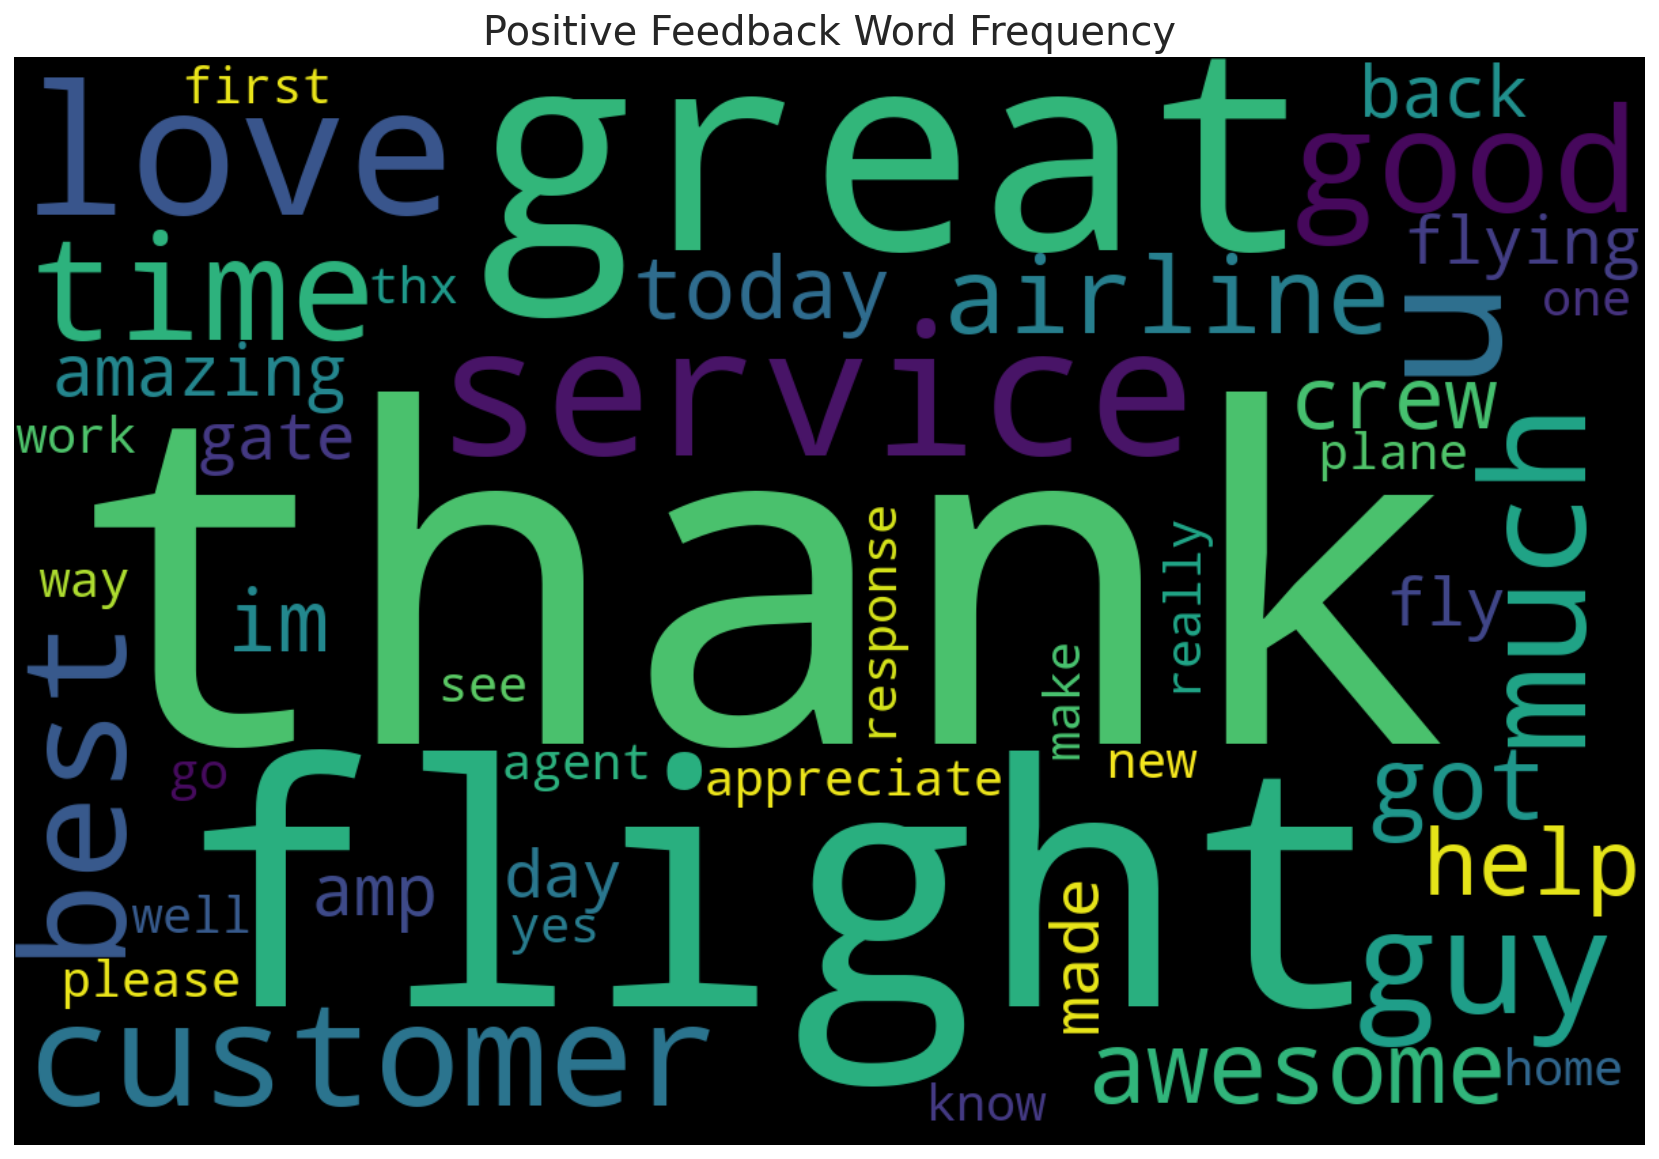

In [47]:
from wordcloud import WordCloud
all_positive_corpus = ' '.join(w[0] for w in freq)
airline_wordcloud = WordCloud(width = 1200, height = 800).generate(all_positive_corpus)


plt.figure(figsize=(20,10))
plt.imshow(airline_wordcloud, interpolation='bilinear')
plt.title('Positive Feedback Word Frequency' , fontsize = 20)
plt.axis("off")
plt.show()

- This bar chart shows us the top 50 most frequent words in positive feedback.The meaningful words that can be spotted in the positive sentiments’ word cloud directly include **“thank”**, **“flight”** and **“great”**. This shows people tend to appreciate the airline on social media when they have positive flight experience

In [48]:
# Showing which words have the most counts in the negative texts within each category.

all_negative_text = df.loc[df.airline_sentiment == 0].text.map(word_tokenize).values
all_negative_corpus = [word for text in all_negative_text for word in text]
freq = FreqDist(all_negative_corpus).most_common(50)

# all_negative_df = pd.DataFrame(freq, columns=['Word', 'Frequency'])
# all_negative_df

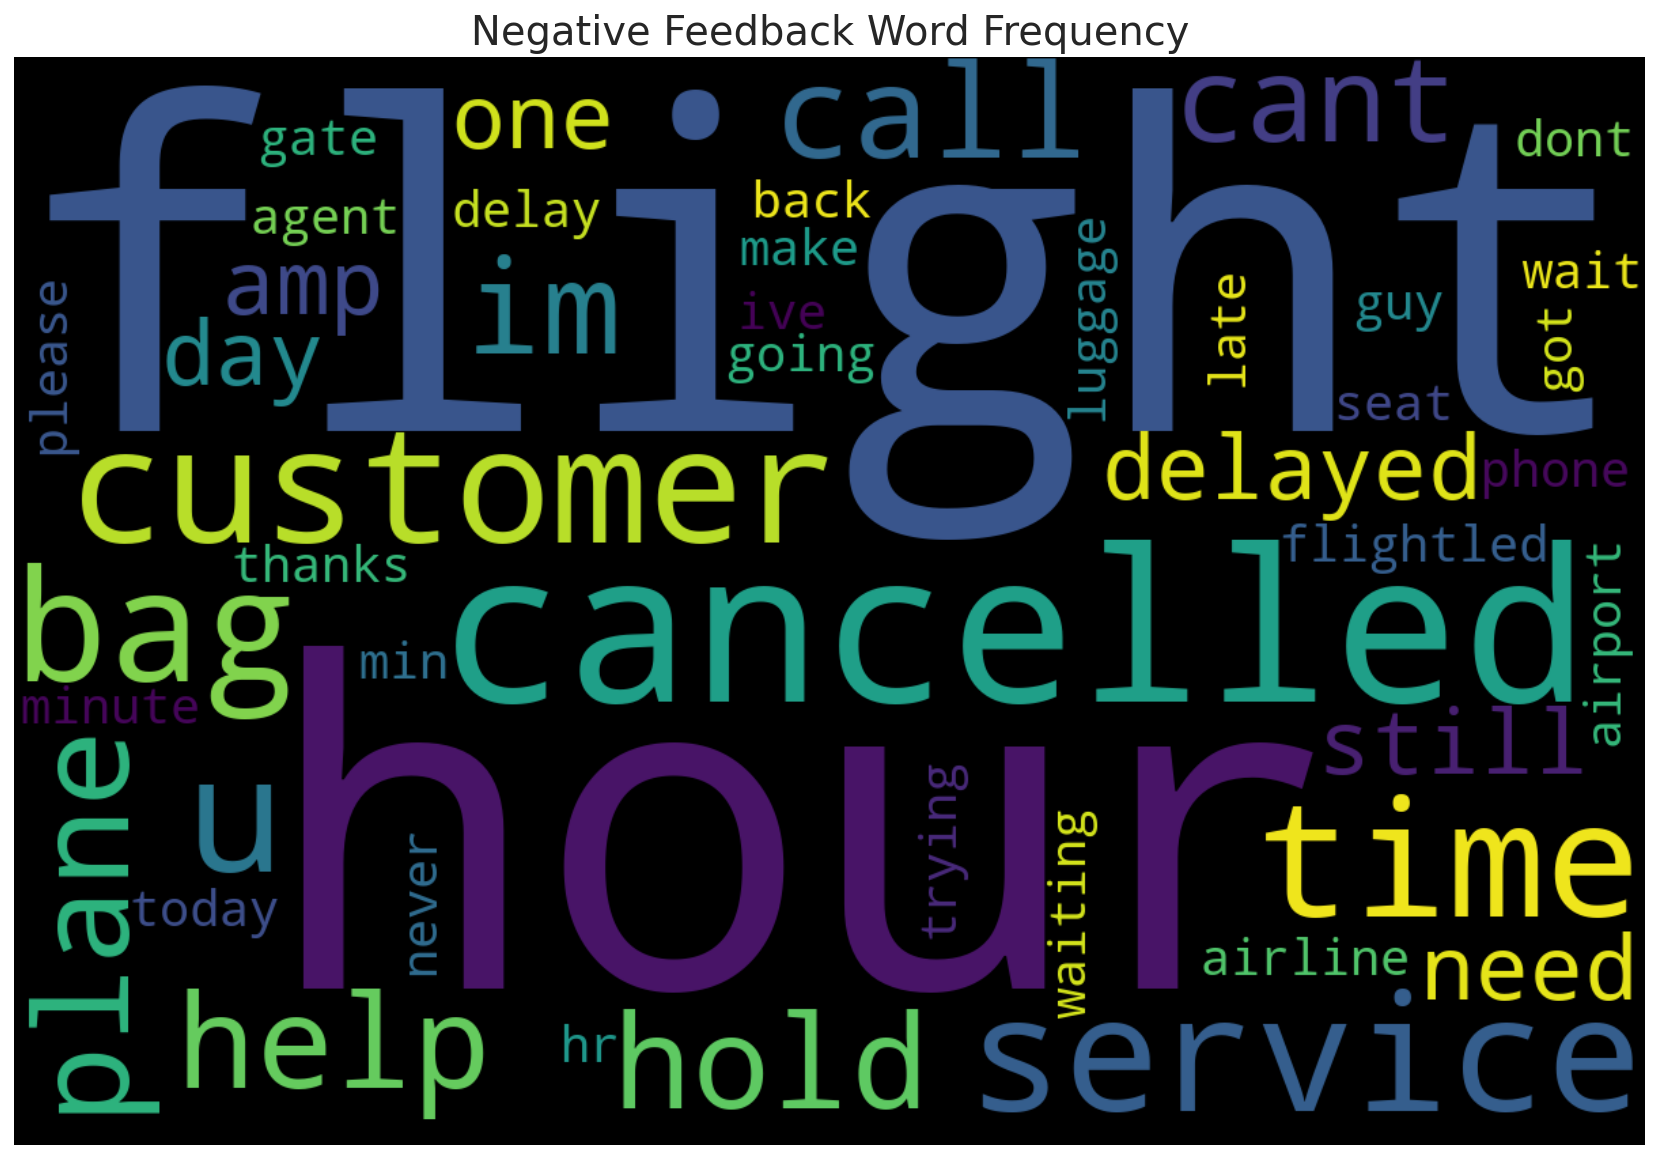

In [49]:
all_negative_corpus = ' '.join(w[0] for w in freq)
airline_wordcloud = WordCloud(width = 1200, height = 800).generate(all_negative_corpus)


plt.figure(figsize=(20,10))
plt.imshow(airline_wordcloud, interpolation='bilinear')
plt.title('Negative Feedback Word Frequency' , fontsize = 20)
plt.axis("off")
plt.show()

- We observe from the word cloud that tweets related to **“cancelled”** are causing the most negative tweets. And also  **"Flight"**, **"hour"**, **"delayed"** have higher frequencies than other words.
- Also, **"cancelled"** shows that flight cancellation maybe the most important reason why customers are showing their negative feedback on Twitter.
- Other complaints were related to **customer service**,**layover**, **bag**,**hold**  and  **call**  as seen in the word cloud.



## Model Preparation

### Vectorization

Now we can make use of **TfidfVectorizer** and **CountVectorizer**  transfer Tweet contents into vectors, in order to train the model in the proper form and shape

So , What Is The Difference Between **TfidfVectorizer** and **CountVectorizer** ?

TF-IDF Vectorizer and Count Vectorizer are both methods used in natural language processing to vectorize text. However, there is a fundamental difference between the two methods.

- **CountVectorizer** simply counts the number of times a word appears in a document (using a bag-of-words approach).

-  **TF-IDF Vectorizer** takes into account not only how many times a word appears in a document but also how important that word is to the whole corpus.

After the vectorization phase, the data will be divide into **“training”** and **“testing”** set. It will be divide in the ratio of 4:1 for training and testing, respectively. Then we will be building predictive models on the dataset using feature set TF-IDF or CountVec. Then we will use logistic regression classifier as baseline model to predict the overall sentiment of future tweets

### CountVec

In [91]:
sample = df.text.sample(n=5 , random_state=1)
sample 

12920                         ive trying get reservation since yesterday make change reservation hold
5724                   whats new inflight wifi service super crappy user experience miss old provider
13026    lost customer today flight today cancelled flightled find calling customer service yesterday
9188                              yeah know doesnt get money back everytime fly something bad happens
7737                          touched neworleans annual national distributor conference livethelegend
Name: text, dtype: object

In [92]:
cv = CountVectorizer()
word_count_vec = cv.fit_transform(sample)
word_count_vec.shape


(5, 46)

In [93]:
cv.get_feature_names()

['annual',
 'back',
 'bad',
 'calling',
 'cancelled',
 'change',
 'conference',
 'crappy',
 'customer',
 'distributor',
 'doesnt',
 'everytime',
 'experience',
 'find',
 'flight',
 'flightled',
 'fly',
 'get',
 'happens',
 'hold',
 'inflight',
 'ive',
 'know',
 'livethelegend',
 'lost',
 'make',
 'miss',
 'money',
 'national',
 'new',
 'neworleans',
 'old',
 'provider',
 'reservation',
 'service',
 'since',
 'something',
 'super',
 'today',
 'touched',
 'trying',
 'user',
 'whats',
 'wifi',
 'yeah',
 'yesterday']

In [94]:
print(cv.vocabulary_)

{'ive': 21, 'trying': 40, 'get': 17, 'reservation': 33, 'since': 35, 'yesterday': 45, 'make': 25, 'change': 5, 'hold': 19, 'whats': 42, 'new': 29, 'inflight': 20, 'wifi': 43, 'service': 34, 'super': 37, 'crappy': 7, 'user': 41, 'experience': 12, 'miss': 26, 'old': 31, 'provider': 32, 'lost': 24, 'customer': 8, 'today': 38, 'flight': 14, 'cancelled': 4, 'flightled': 15, 'find': 13, 'calling': 3, 'yeah': 44, 'know': 22, 'doesnt': 10, 'money': 27, 'back': 1, 'everytime': 11, 'fly': 16, 'something': 36, 'bad': 2, 'happens': 18, 'touched': 39, 'neworleans': 30, 'annual': 0, 'national': 28, 'distributor': 9, 'conference': 6, 'livethelegend': 23}


In [95]:
word_count_vec.toarray()

array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1,
        0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0,
        0, 1],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0]])

In [96]:
df_cv =pd.DataFrame(word_count_vec.toarray() , columns = cv.get_feature_names())
df_cv

,annual,back,bad,calling,cancelled,change,conference,crappy,customer,distributor,...,something,super,today,touched,trying,user,whats,wifi,yeah,yesterday
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,1,1,0,0
2,0,0,0,1,1,0,0,0,2,0,...,0,0,2,0,0,0,0,0,0,1
3,0,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0


### TF-IDF

In [97]:
tfidf = TfidfVectorizer()
tfidf_vec = tfidf.fit_transform(sample)
tfidf_vec.shape

(5, 46)

In [98]:
tfidf.get_feature_names()[:20]

['annual',
 'back',
 'bad',
 'calling',
 'cancelled',
 'change',
 'conference',
 'crappy',
 'customer',
 'distributor',
 'doesnt',
 'everytime',
 'experience',
 'find',
 'flight',
 'flightled',
 'fly',
 'get',
 'happens',
 'hold']

In [99]:
print(tfidf.vocabulary_)

{'ive': 21, 'trying': 40, 'get': 17, 'reservation': 33, 'since': 35, 'yesterday': 45, 'make': 25, 'change': 5, 'hold': 19, 'whats': 42, 'new': 29, 'inflight': 20, 'wifi': 43, 'service': 34, 'super': 37, 'crappy': 7, 'user': 41, 'experience': 12, 'miss': 26, 'old': 31, 'provider': 32, 'lost': 24, 'customer': 8, 'today': 38, 'flight': 14, 'cancelled': 4, 'flightled': 15, 'find': 13, 'calling': 3, 'yeah': 44, 'know': 22, 'doesnt': 10, 'money': 27, 'back': 1, 'everytime': 11, 'fly': 16, 'something': 36, 'bad': 2, 'happens': 18, 'touched': 39, 'neworleans': 30, 'annual': 0, 'national': 28, 'distributor': 9, 'conference': 6, 'livethelegend': 23}


In [100]:
tfidf_vec.toarray()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.29745795, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.2399872 , 0.        , 0.29745795,
        0.        , 0.29745795, 0.        , 0.        , 0.        ,
        0.29745795, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.59491589, 0.        ,
        0.29745795, 0.        , 0.        , 0.        , 0.        ,
        0.29745795, 0.        , 0.        , 0.        , 0.        ,
        0.2399872 ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.29296785, 0.        , 0.        ,
        0.        , 0.        , 0.29296785, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.29296785, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.29296

In [101]:
df_tfidf =pd.DataFrame(tfidf_vec.toarray() , columns = tfidf.get_feature_names())
df_tfidf

,annual,back,bad,calling,cancelled,change,conference,crappy,customer,distributor,...,something,super,today,touched,trying,user,whats,wifi,yeah,yesterday
0,0.000000,0.000000,0.000000,0.00000,0.00000,0.297458,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.297458,0.000000,0.000000,0.000000,0.000000,0.239987
1,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.292968,0.000000,0.000000,...,0.000000,0.292968,0.000000,0.000000,0.000000,0.292968,0.292968,0.292968,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.25564,0.25564,0.000000,0.000000,0.000000,0.511279,0.000000,...,0.000000,0.000000,0.511279,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.206248
3,0.000000,0.306413,0.306413,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.306413,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.306413,0.000000
4,0.377964,0.000000,0.000000,0.00000,0.00000,0.000000,0.377964,0.000000,0.000000,0.377964,...,0.000000,0.000000,0.000000,0.377964,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
